# Lab 12: Modeling

This lab is meant to be short so you can experiment with multiple models, feature engineering methods, etc.

## #1

Build a model using the flights data to predict departure delay. Remember to split your data, examine your data, select features, choose some models to try, train the models, and choose one (possibly based on scoring the models).
- Be careful to avoid leakage! Make sure all of your features make sense as predictors.
- Think: do you need a classification or regression model?
    - Some regression models: Linear Regression, Lasso Regression, Decision Tree Regressor, Random Forest Regressor
    - Some classification models: Gaussian Naive Bayes, Decision Tree Classifier, Random Forest Classifier
- You will find that our features include some categorical variables. We did not spend much time on how to deal with categorical (non-numeric) variables in class. You may either A) drop these features or B) if you're feeling ambitious, look into a technique like one-hot encoding. Look at `sklearn.preprocessing.OneHotEncoder`, or the simpler `pd.get_dummies`.

Note that you may not be able to build a very predictive model without substantial feature engineering.
Consider why this might be so.
Would supplemental data improve your model?

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [122]:
flights = pd.read_csv('data/flights.csv')
flights.dropna(inplace = True)

In [124]:
flights.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour'],
      dtype='object')

# The data will be split into train (70%) and test (30%).

The predictor and target variables are created where the categorical variables are not selected.

In [39]:
# create training and testing vars
X1 = flights[['year', 'month', 'day', 'dep_time', 'sched_dep_time',
              'arr_time', 'sched_arr_time', 'arr_delay', 'flight',
              'air_time', 'distance', 'hour', 'minute']]
y1 = flights['dep_delay']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 8908)
print(len(flights))
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

327346
(229142, 13) (229142,)
(98204, 13) (98204,)


# The response variable dep_delay is continuous and therefore we will build a regression model.

At first, all the numeric variables will be included as predictors to build a linear regression model.

In [88]:
# Linear Regression - all numeric variables

from sklearn.linear_model import LinearRegression
model1 = LinearRegression(fit_intercept = True)
model1 = model1.fit(X1_train, y1_train)
model1.score(X1_train, y1_train)

0.8765718887418317

In [41]:
model1_test = model1.fit(X1_test, y1_test)
pred1 = model1_test.predict(X1_test)
print(model1_test.score(X1_test, y1_test))

0.874760474338583


Text(0, 0.5, 'Predictions')

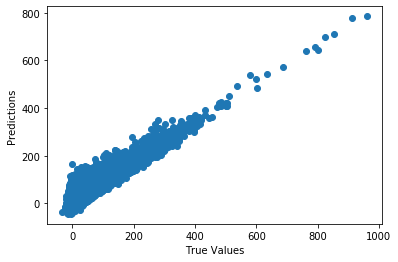

In [42]:
plt.scatter(y1_test, pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')

Now, recursive feature elimination (RFE) will be used for feature selection.

In [98]:
# Variable selection using RFE
#no of features
nof_list = np.arange(1,14)            
high_score = 0
#Variable to store the optimum features
nof = 0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X1_train,y1_train)
    X_test_rfe = rfe.transform(X1_test)
    model.fit(X_train_rfe,y1_train)
    score = model.score(X_test_rfe,y1_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.874704


It can be observed that instead of 13, the model can be built using 11 predictor variables without any significant change in test data performance.

In [109]:
# Initializing RFE model
model2 = LinearRegression()

# Initializing RFE model
modelrfe = RFE(model2, 11)

# Transforming data using RFE
X_rfe = modelrfe.fit_transform(X1_train, y1_train)
model2.fit(X_rfe, y1_train)
print(modelrfe.support_)
print(modelrfe.ranking_)

X_rfe_test = modelrfe.fit_transform(X1_test, y1_test)
model2.score(X_rfe_test, y1_test)

[False  True  True  True  True  True  True  True  True  True  True False
  True]
[3 1 1 1 1 1 1 1 1 1 1 2 1]


0.874703546986666

The 11 variables used in the model are displayed below.

In [111]:
# Fitting the data to model
# Fitting the data to model 
model2.fit(X_rfe, y1_train)
cols = list(X1_train.columns)
temp = pd.Series(modelrfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['month', 'day', 'dep_time', 'sched_dep_time', 'arr_time',
       'sched_arr_time', 'arr_delay', 'flight', 'air_time', 'distance',
       'minute'],
      dtype='object')


Let's use another variable selection method - LASSO and build the model.

In [112]:
# LASSO Regression
reg = LassoCV()
reg.fit(X1_train, y1_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X1_train,y1_train))
coef = pd.Series(reg.coef_, index = X1_train.columns)

Best alpha using built-in LassoCV: 5.059781
Best score using built-in LassoCV: 0.876107


In [76]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 5 variables


Here, it can be observed that LASSO selects only 8 variables and provides similar results as above.

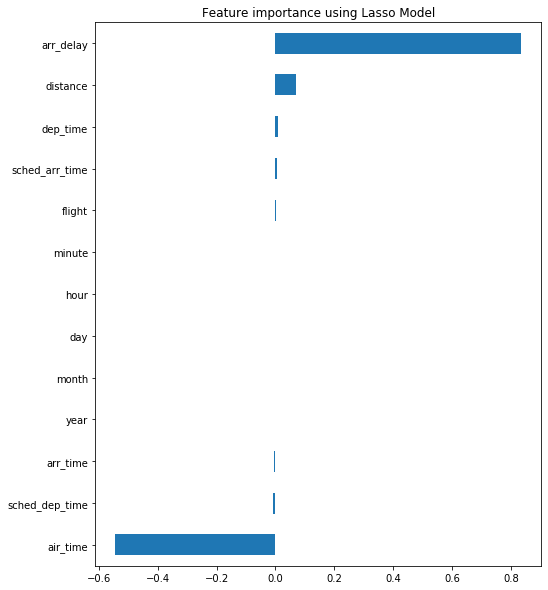

In [89]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model");

In [113]:
model3 = LinearRegression(fit_intercept = True)
X1_train_las = X1_train[['arr_delay', 'distance', 'dep_time', 'sched_arr_time', 'flight', 'arr_time', 'sched_dep_time', 'air_time']].reset_index()
X1_test_las = X1_test[['arr_delay', 'distance', 'dep_time', 'sched_arr_time', 'flight', 'arr_time', 'sched_dep_time', 'air_time']].reset_index()

model3 = model3.fit(X1_train_las, y1_train)
model3.score(X1_test_las, y1_test)

0.8757248952497589

Till now, only linear models were used. Now, a tree like model named Decision Tree will be built to predict the response.

In [128]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

rt = DecisionTreeRegressor()
regtree = rt.fit(X1_train, y1_train)
regtree

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [129]:
regtree.score(X1_test, y1_test)

0.9539950801817098